# 泰坦尼克号介绍

本实验同样来源于 Kaggle 的入门项目之一  泰坦尼克号存活率预测 。下面我们来对其进行简要讲述一下。
泰坦尼克号的沉没是历史上最著名的沉船事件之一。 1912 年 4 月 15 日，泰坦尼克号在处女航中撞上冰山沉没，2224 名乘客和船员中 1502 人遇难。这一耸人听闻的悲剧震惊了当时的国际社会。
图片描述
沉船造成如此巨大人员伤亡的原因之一是没有足够的救生艇来容纳乘客和船员。虽然在沉船事件中幸存下来也有一些运气的因素，但有些人比其他人更有可能幸存下来，比如妇女、儿童和上层阶级。
而存活率预测就是对船上的乘客进行分析，预测乘客是否在这场灾难中存活下来，即运用机器学习工具来预测哪些乘客在灾难中幸存下来。

In [1]:
import numpy as np
import random as rnd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
df = pd.read_csv( 'https://labfile.oss.aliyuncs.com/courses/1363/Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数值型： Age, Fare. Discrete: SibSp, Parch；
类别型： Survived, Sex, and Embarked. Ordinal: Pclass.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#查看类别型的特征 O 大写的字母o， 不是zero

df.describe(include=['O']) 

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Laroche, Miss. Simonne Marie Anne Andree",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


从上面的结果可以看到，名字特征列（name）可以取 891 个不同的值，这意味着每位乘客的名字都不一样，与事实相符。同时还可以看到，性别（sex）含有两类，其中男性（male） 有 577 个。其他列的情况可以以此类推。

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

从直观上来判断，船舱号跟是否存活没有多大的关系，因此这直接删除掉该列。同样的道理，也删除乘客编号（PassengerId）和船票号列（Ticket）。

In [8]:
df_drop = df.drop(['PassengerId', 'Cabin','Ticket'], axis=1)
df_drop.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# 数据挖掘

现在对数进行挖掘，通过原始数据挖掘出可能与存活率相关的信息。原始数据集的 SibSp 列表示的是家庭人数，即一个乘客含有多少个兄弟姐妹或配偶，在Parch 列中，记录的是一个乘客含有多少个父母或孩子。将这两者相加，再加上他自己就可以得到一个家庭的总人数。提取这个特征的原因是，有可能获救的人都是一个家庭的。

#这种加法没有重叠么？

In [9]:
df_drop['FamilySize'] = df_drop['SibSp'] + df_drop['Parch'] + 1
df_drop['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [10]:
df_drop['IsAlone'] = 1
df_drop['IsAlone'].loc[df_drop['FamilySize']>1] = 0
df_drop['IsAlone'].value_counts()

1    537
0    354
Name: IsAlone, dtype: int64

为什么会有0呢

In [11]:
df_drop['Title'] = df_drop['Name'].str.split(
   ",", expand=True)[1].str.split(".", expand=True)[0]

In [12]:
df_drop['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Col               2
 Major             2
 Sir               1
 the Countess      1
 Capt              1
 Jonkheer          1
 Ms                1
 Lady              1
 Don               1
 Mme               1
Name: Title, dtype: int64

In [13]:
stat_min = 10
title_names = (df_drop['Title'].value_counts() < stat_min)
df_drop['Title'] = df_drop['Title'].apply(
   lambda x: "Misc" if title_names.loc[x] == True else x)
print(df_drop['Title'].value_counts())
print("-"*10)

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64
----------


In [14]:
df_drop["AgeBin"] = pd.cut(df_drop['Age'].astype(int), 5)
df_drop['AgeBin'].value_counts()

(16.0, 32.0]     525
(32.0, 48.0]     186
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: AgeBin, dtype: int64

In [15]:
df_drop['FareBin'] = pd.qcut(df_drop['Fare'], 4)
df_drop['FareBin'].value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: FareBin, dtype: int64

In [16]:
df_drop.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(16.0, 32.0]","(-0.001, 7.91]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(32.0, 48.0]","(31.0, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(16.0, 32.0]","(7.91, 14.454]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(32.0, 48.0]","(31.0, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(32.0, 48.0]","(7.91, 14.454]"


In [17]:
df_drop[['Sex', 'Survived']].groupby('Sex', as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [18]:
df_drop[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [19]:
df_drop[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [20]:
df_drop[['Title', 'Survived']].groupby('Title', as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.697802
2,Mr,0.156673
3,Mrs,0.792000
4,Misc,0.444444


In [21]:
df_drop[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [22]:
df_drop[['Parch', 'Survived']].groupby('Parch', as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [23]:
df_drop[['FamilySize', 'Survived']].groupby('FamilySize', as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [24]:
df_drop[['IsAlone', 'Survived']].groupby('IsAlone', as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

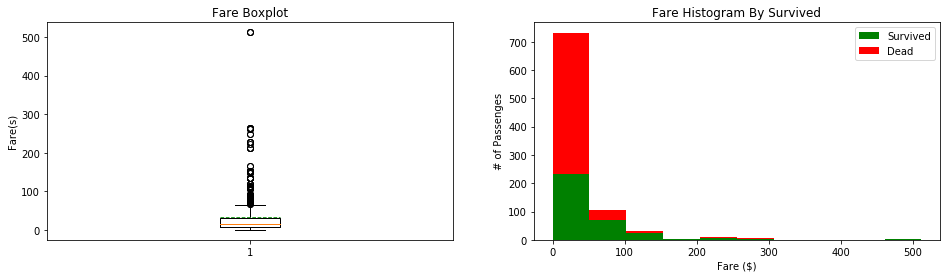

In [26]:
plt.figure(figsize=[16, 4])
plt.subplot(121)
plt.boxplot(x=df_drop['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare(s)')
plt.subplot(122)
plt.hist(x=[df_drop[df_drop['Survived'] == 1]['Fare'],
            df_drop[df_drop['Survived'] == 0]['Fare']],
            stacked=True, color=['g', 'r'], label=['Survived','Dead'])
plt.title('Fare Histogram By Survived')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passenges')
plt.legend()

从上图可知，大多数乘客的票价都不会超过 100 。此外，从右图可知，票价越低，死亡率越高。同样的方法绘制出年龄（Age）列。

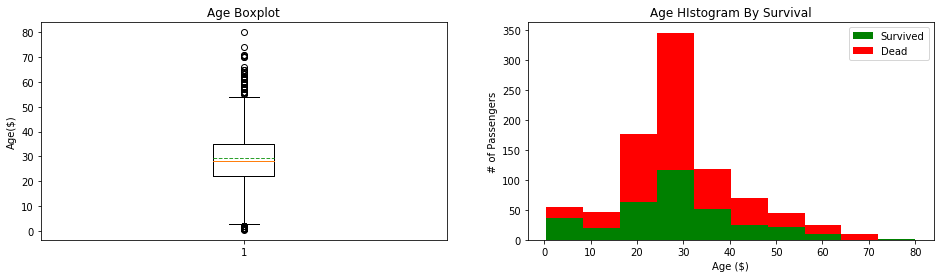

In [27]:
plt.figure(figsize=[16, 4])
plt.subplot(121)
plt.boxplot(x=df_drop['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age($)')
plt.subplot(122)
plt.hist(x=[df_drop[df_drop['Survived'] == 1]['Age'], df_drop[df_drop['Survived'] == 0]['Age']],
        stacked=True, color=['g', 'r'], label=['Survived', 'Dead'])
plt.title('Age HIstogram By Survival')
plt.xlabel('Age ($)')
plt.ylabel('# of Passengers')
plt.legend()

从箱线图可以看出，乘客的年龄主要集中在 30 岁左右，从右图可以看出，30 岁左右的人死亡率最高。

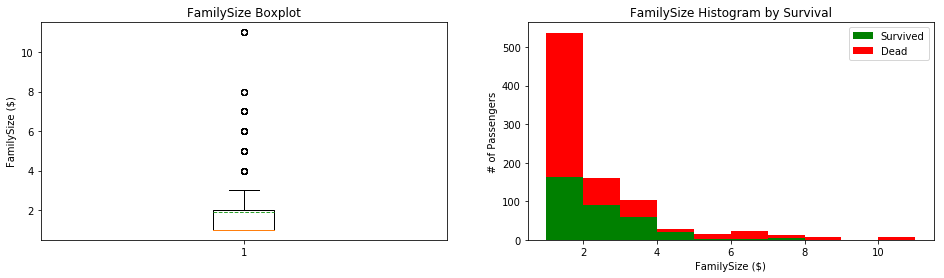

In [28]:
plt.figure(figsize=[16, 4])
# 画第一个图
plt.subplot(121)
plt.boxplot(x=df_drop['FamilySize'], showmeans=True, meanline=True)
plt.title('FamilySize Boxplot')
plt.ylabel('FamilySize ($)')
# 画第二个图
plt.subplot(122)
plt.hist(x=[df_drop[df_drop['Survived'] == 1]['FamilySize'], df_drop[df_drop['Survived'] == 0]['FamilySize']],
         stacked=True, color=['g', 'r'], label=['Survived', 'Dead'])
plt.title('FamilySize Histogram by Survival')
plt.xlabel('FamilySize ($)')
plt.ylabel('# of Passengers')
plt.legend()

从上图可以看出，家庭人数主要集中在 1 到 2 个人。右图显示家庭人数超过 5 个人的，大部分都没有存活下来。

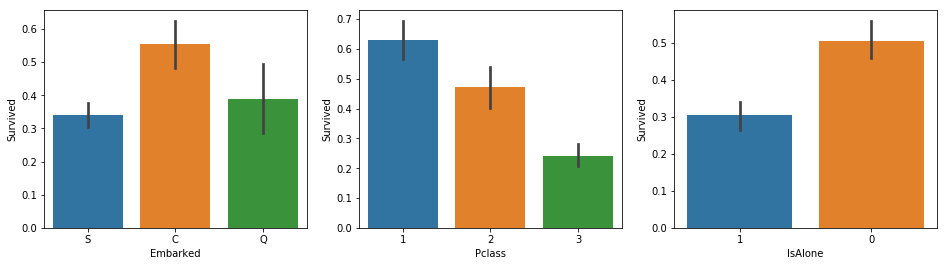

In [29]:
fig, saxis = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(x='Embarked', y='Survived', data=df_drop, ax=saxis[0])
sns.barplot(x='Pclass', y='Survived', order=[1,2,3], data=df_drop, ax=saxis[1])
sns.barplot(x='IsAlone', y='Survived', order=[1,0], data=df_drop, ax= saxis[2])

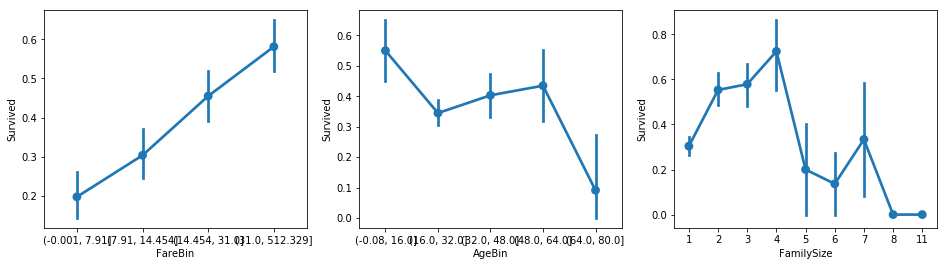

In [30]:
fig, saxis = plt.subplots(1, 3, figsize=(16, 4))
sns.pointplot(x='FareBin', y='Survived', data=df_drop, ax=saxis[0])
sns.pointplot(x='AgeBin', y='Survived', data=df_drop, ax=saxis[1])
sns.pointplot(x='FamilySize', y='Survived', data=df_drop, ax=saxis[2])


Text(0.5, 1.0, 'Pclass vs Family Size survival Comparison')

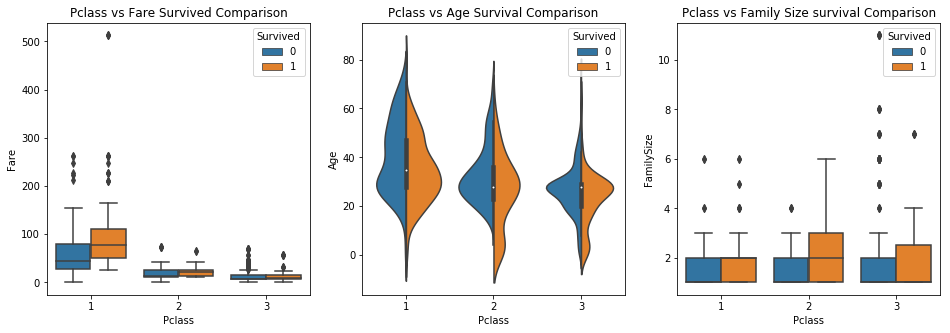

In [31]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(16, 5))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df_drop, ax=axis1)
axis1.set_title('Pclass vs Fare Survived Comparison')
sns.violinplot(x='Pclass', y='Age', hue='Survived',
             data=df_drop, split=True, ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparison')
sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=df_drop, ax=axis3)
axis3.set_title('Pclass vs Family Size survival Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone')

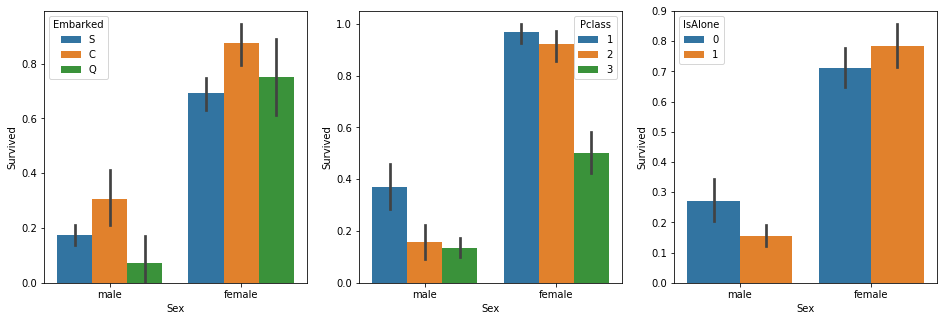

In [32]:
fig, qaxis = plt.subplots(1, 3, figsize=(16, 5))
sns.barplot(x='Sex', y='Survived', hue='Embarked', data=df_drop, ax=qaxis[0])
axis1.set_title('Sex vs Embarked')

sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df_drop, ax=qaxis[1])
axis1.set_title('Sex vs Pclass')

sns.barplot(x='Sex', y='Survived', hue='IsAlone', data=df_drop, ax=qaxis[2])
axis1.set_title('Sex vs IsAlone')

从上图中可以看到，女性的存活率普遍都高于男性的存活率。但在最右边的图中，男性单身汉死亡率高一点，而非单身汉死亡率要低一些。对于女性正好相反，单身女性的死亡率要低一些。非单身女性死亡率要高一些

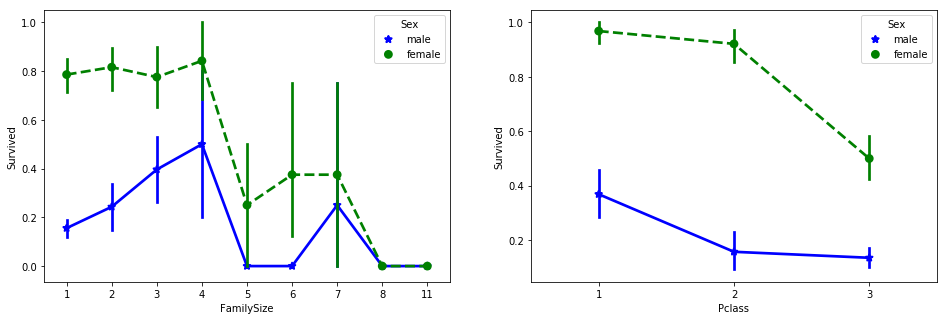

In [33]:
fig, (maxis1, maxis2) = plt.subplots(1,2,figsize=(16, 5))
sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=df_drop,
             palette={'male': 'blue','female':"g"},
             markers=['*', 'o'], linestyles=['-', '--'], ax=maxis1)
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_drop,
             palette={"male": "blue","female":"g"},
             markers=['*', 'o'], linestyles=['-', '--'], ax=maxis2)

由左图可知，在家庭人数在 1 到 4 区间，男性的存活率在增加，而女性的存活率似乎没有太多的变化。而在右图中，船舱等级为 2 到 3 时，男性的存活率变化微小，而女性的存活率在大幅降低。

/Users/jingduan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jingduan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


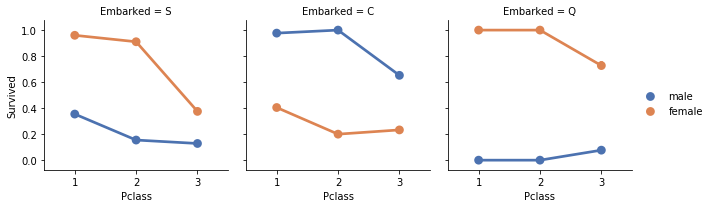

In [34]:
e = sns.FacetGrid(df_drop, col='Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=9.0, 
     palette='deep')
e.add_legend()

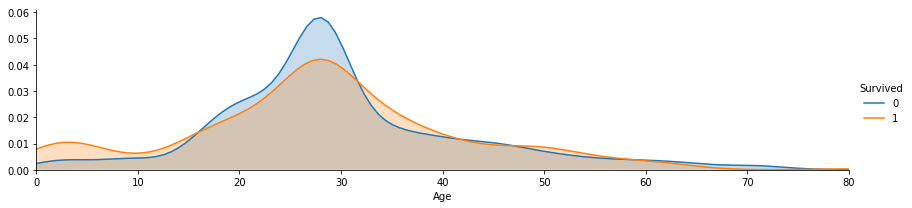

In [35]:
a = sns.FacetGrid(df_drop, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, df_drop['Age'].max()))
a.add_legend()

从上图可以看出，登船乘客的年龄大部分为年轻人，死亡人数超过存活人数的群体也都是在 20 岁到 33 岁区间。

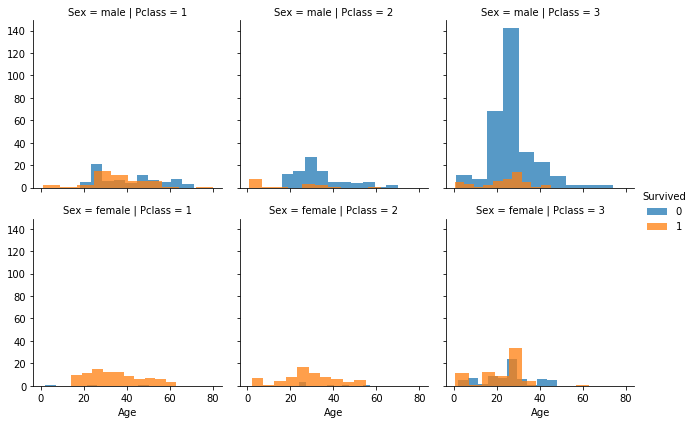

In [36]:
h = sns.FacetGrid(df_drop, row='Sex', col='Pclass', hue='Survived')
h.map(plt.hist, 'Age', alpha=.75)
h.add_legend()

从上图可以看到，年龄在 20 岁到 40 之间，船舱等级为 3 的男性死亡率最高。

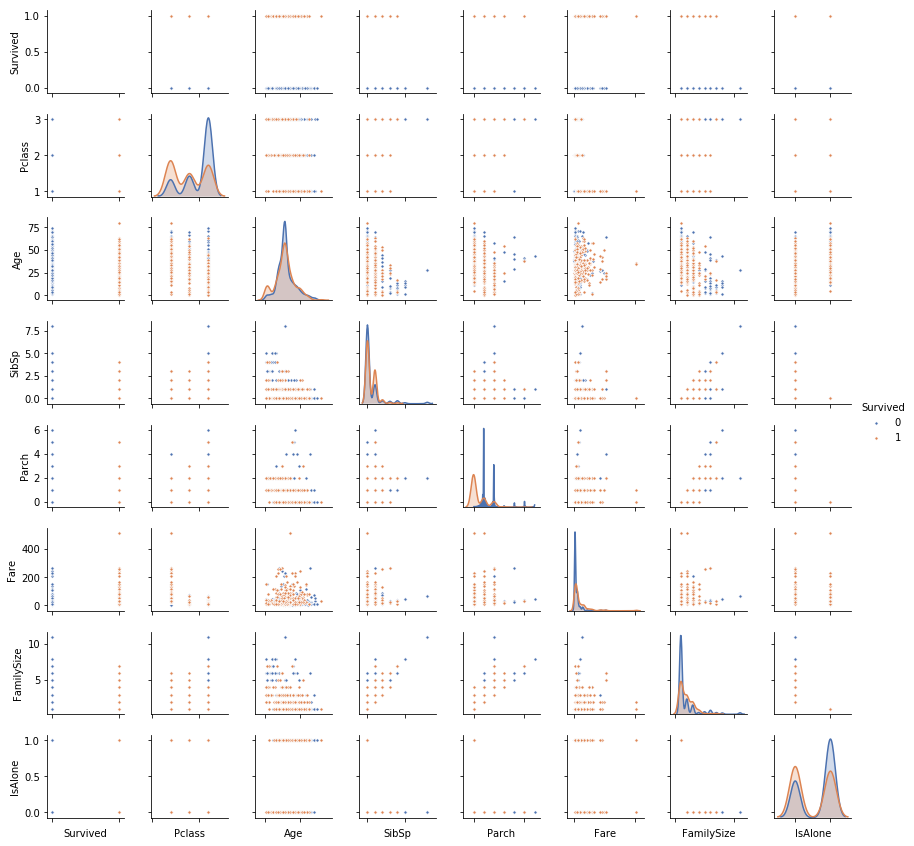

In [37]:
pp = sns.pairplot(df_drop, hue='Survived', palette='deep', height=1.5,
                 diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])

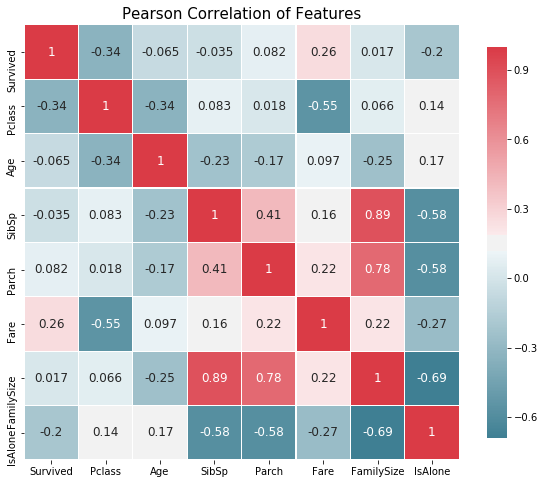

In [38]:
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(10, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(
        df.corr(),
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1, vmax=1.0, linecolor='white',
        annot_kws={'fontsize': 12})
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
correlation_heatmap(df_drop)

在上图中，数值越接近于 1 表示越正相关，越接近于 -1 表示越负相关。

# 数据转换

到目前为止，我们已经完成了数据清洗和数据分析。接下来准备构建预测模型。由于经过上面的数据预处理之后，数据中还是存在一些用字符串来表示的类别型特征，因此在构建模型之前先将这些字符串转化为数值。这里之间使用 sklearn 提供的接口来完成。

In [39]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [44]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df_drop['Sex_Code'] = label.fit_transform(df_drop['Sex'])
df_drop['Embarked_Code'] = label.fit_transform(df_drop['Embarked'])
df_drop['Title_Code'] = label.fit_transform(df_drop['Title'])
df_drop['AgeBin_Code'] = label.fit_transform(df_drop['AgeBin'])
df_drop['FareBin_Code'] = label.fit_transform(df_drop['FareBin'])

In [45]:
df_drop.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(16.0, 32.0]","(-0.001, 7.91]",1,2,2,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(32.0, 48.0]","(31.0, 512.329]",0,0,3,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(16.0, 32.0]","(7.91, 14.454]",0,2,1,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(32.0, 48.0]","(31.0, 512.329]",0,2,3,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(32.0, 48.0]","(7.91, 14.454]",1,2,2,2,1


In [47]:
df_drop.shape

(891, 19)

In [48]:
df_drop.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'FamilySize', 'IsAlone', 'Title', 'AgeBin', 'FareBin',
       'Sex_Code', 'Embarked_Code', 'Title_Code', 'AgeBin_Code',
       'FareBin_Code'],
      dtype='object')

在上面的显示结果中，从 Survived 列到 Embarked 列为原始数据的特征列，后面的特征列为我们所提取或构件的特征列。其中含 Code 的列只是将对应的列转化为数字而已。

在训练模型时，我们仅选择使用一部分的特征列来训练。

#为什么要选这些呢

In [49]:
feat_cols = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
target = 'Survived'

In [50]:
data_X = df_drop[feat_cols]
data_X.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
0,1,3,2,2,2,1,0
1,0,1,0,3,2,2,3
2,0,3,2,1,1,1,1
3,0,1,2,3,2,2,3
4,1,3,2,2,1,2,1


In [51]:
data_X.shape

(891, 7)

In [53]:
data_y = df_drop[target]
data_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# 构建预测模型

In [63]:
#在构建模型之前，先划分训练集和测试集。
from sklearn import model_selection
train_x, test_x, train_y, test_y = model_selection.train_test_split(data_X.values,
                                                                   data_y.values,
                                                                   random_state=0)

构建模型，这里先使用  逻辑回归 来完成。

In [61]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs')
model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
from sklearn import metrics
y_pred = model.predict(test_x)
metrics.accuracy_score(y_pred, test_y)

0.7937219730941704

从测试集的结果来看，使用逻辑回归得到的准确率没有达到 80% ，这里我们换一种常用的分类方法： 支持向量机 。

In [65]:
from sklearn.svm import SVC
model = SVC(probability=True, gamma='auto')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
metrics.accuracy_score(y_pred, test_y)

0.8251121076233184

从上面的结果可以看到，支持向量机比逻辑回归的结果稍微好一点点。但还是不理想。我们再换另一种方法： 随机森林。

In [67]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
metrics.accuracy_score(y_pred, test_y)

0.8475336322869955

决策树

In [74]:
from sklearn.feature_extraction import DictVectorizer

dvec= DictVectorizer(sparse=False)
data_X = dvec.fit_transform(data_X.to_dict(orient='record'))

In [75]:
from sklearn.tree import DecisionTreeClassifier
clf =DecisionTreeClassifier(criterion='entropy')
clf.fit(data_X, data_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [81]:
#test_x=dvec.transform(test_x.to_dict(orient='record'))
pred_labels = clf.predict(test_x)

In [88]:
acc_decision_tree =round(clf.score(data_X, data_y), 6)
print(u'score %.4lf' % acc_decision_tree)

score 0.8866


# 实验总结

泰坦尼克号数据的分析过程，具体为，数据清洗、数据预处理、特征工程、数据可视化、建立模型等。在数据可视化中，使用到了许多的可视化技巧。在构建模型时，我们主要使用了三种方法，分别是逻辑回归、支持向量机、随机森林。这些方法都涉及到复杂的数学推导